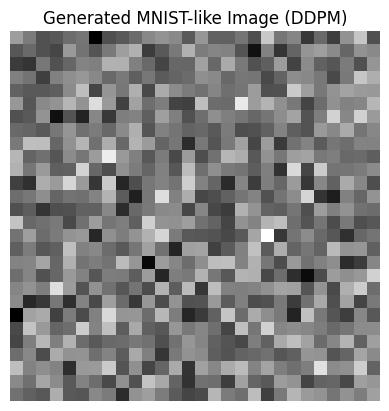

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return tf.linspace(beta_start, beta_end, timesteps)


# DDPM parameters
TIMESTEPS = 1000
betas = linear_beta_schedule(TIMESTEPS)
alphas = 1 - betas
alphas_cumprod = tf.math.cumprod(alphas)


def get_model():
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(28 * 28, activation='linear')(x)
    outputs = tf.keras.layers.Reshape((28, 28, 1))(x)
    return tf.keras.Model(inputs, outputs)


model = get_model()


def sample(model, shape=(28, 28, 1), timesteps=TIMESTEPS):
    x = tf.random.normal((1, *shape))  # Start from random noise

    for t in reversed(range(timesteps)):
        predicted_noise = model(x, training=False)

        alpha_t = alphas[t]
        alpha_cumprod_t = alphas_cumprod[t]
        beta_t = betas[t]

        coef1 = 1 / tf.sqrt(alpha_t)
        coef2 = (1 - alpha_t) / tf.sqrt(1 - alpha_cumprod_t)

        x = coef1 * (x - coef2 * predicted_noise)

        if t > 0:
            noise = tf.random.normal(shape=(1, *shape))
            sigma_t = tf.sqrt(beta_t)
            x += sigma_t * noise

    return x


def run_pipeline():
    generated_image = sample(model)
    generated_image = (generated_image + 1) / 2  # Normalize to [0, 1]

    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.title("Generated MNIST-like Image (DDPM)")
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    run_pipeline()